In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
from torch.distributions.multivariate_normal import MultivariateNormal

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

device: cpu


In [11]:
n = 200 # number of samples
max_dim = 600

smallest_d= torch.arange(0,5,1)          # very small dim
smaller_d = torch.arange(5,170,5)        # dim sufficiently smaller than n
small_d   = torch.arange(170,196,2)      # dim close to but smaller than n
around    = torch.arange(196,204,1)      # dim around n
large_d   = torch.arange(204,250,2)      # dim close to but bigger than n
larger_d  = torch.arange(250,max_dim,5)  # dim sufficiently bigger than n

d_vals = torch.cat([smallest_d, smaller_d, small_d,around,large_d, larger_d])
M = d_vals.size()[0]
print(f'We set {M} candidates for # of dimensions.')

sim = 40 # number of simulations for each dim candidate

We set 152 candidates for # of dimensions.


In [13]:
sigma1 = 0.1 # SNR = 1/sigma^2 = 100
sigma2 = 0.5 # SNR = 4
sigma3 = 1   # SNR = 1

sigmas = [sigma1, sigma2, sigma3]

In [14]:
# Creating X and Y for each dimension and running 40 simulations
def run_simulation(d_vals, num_sim, s):
    M = d_vals.size()[0]
    train_mse = torch.zeros((M, num_sim))
    test_mse  = torch.zeros((M, num_sim))
    for i in range(M):
        for j in range(num_sim):
            mean = torch.zeros((d_vals[i],))
            Id = torch.eye(d_vals[i]) # Identity matrix
            norm = MultivariateNormal(mean, Id)
            X_train = norm.sample(sample_shape=(n,)) # X training data
            X_test  = norm.sample(sample_shape=(n,)) # X testing data

            # Generate the true beta (weights) with norm = 1
            beta = torch.rand(d_vals[i])
            beta = beta / torch.linalg.norm(beta)

            # Generate the random gaussian noise
            noise1 = torch.normal(torch.zeros((n,)), torch.full((n,), s))
            noise2 = torch.normal(torch.zeros((n,)), torch.full((n,), s))

            # Generate training and testing responses
            Y_train = torch.matmul(X_train, beta) + noise1
            Y_test = torch.matmul(X_test, beta) + noise2

            if n < d_vals[i]:
                beta_hat = torch.matmul(torch.linalg.pinv(X_train), Y_train)
            else:
                p1 = torch.linalg.inv(torch.matmul(torch.t(X_train), X_train))
                p2 = torch.matmul(p1, torch.t(X_train))
                beta_hat = torch.matmul(p2,Y_train)

            train_pred = torch.matmul(X_train, beta_hat)
            test_pred  = torch.matmul(X_test,  beta_hat)
            train_mse[i,j] = torch.mean((Y_train - train_pred)**2)
            test_mse[i,j]  = torch.mean((Y_test - test_pred)**2)

    return train_mse, test_mse

In [15]:
# NOTE: it takes about 1min+30s to run this cell on Macbook Air 2021 M1 cpu.

train_mse_s1, test_mse_s1 = run_simulation(d_vals, sim, s=sigma1)
train_mse_s2, test_mse_s2 = run_simulation(d_vals, sim, s=sigma2)
train_mse_s3, test_mse_s3 = run_simulation(d_vals, sim, s=sigma3)

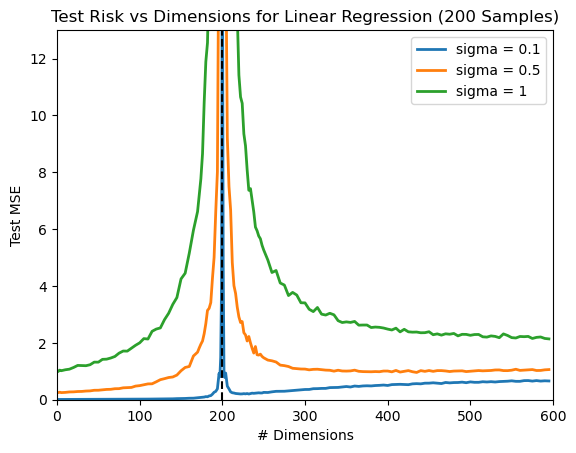

In [16]:
avgs_test_s1 = torch.mean(test_mse_s1, 1)
avgs_test_s2 = torch.mean(test_mse_s2, 1)
avgs_test_s3 = torch.mean(test_mse_s3, 1)

avgs_train_s1 = torch.mean(train_mse_s1, 1)
avgs_train_s2 = torch.mean(train_mse_s2, 1)
avgs_train_s3 = torch.mean(train_mse_s3, 1)

plt.title("Test Risk vs Dimensions for Linear Regression (200 Samples)")
plt.xlabel("# Dimensions")
plt.ylabel("Test MSE")
plt.ylim(0, 13)
plt.xlim(0, max_dim)
plt.plot(d_vals.cpu().numpy(), avgs_test_s1.cpu().numpy(), lw=2, label='sigma = 0.1')
plt.plot(d_vals.cpu().numpy(), avgs_test_s2.cpu().numpy(), lw=2, label='sigma = 0.5')
plt.plot(d_vals.cpu().numpy(), avgs_test_s3.cpu().numpy(), lw=2, label='sigma = 1')
plt.axvline(x=n, color='black', ls='--')
plt.legend(loc="best")
plt.show()

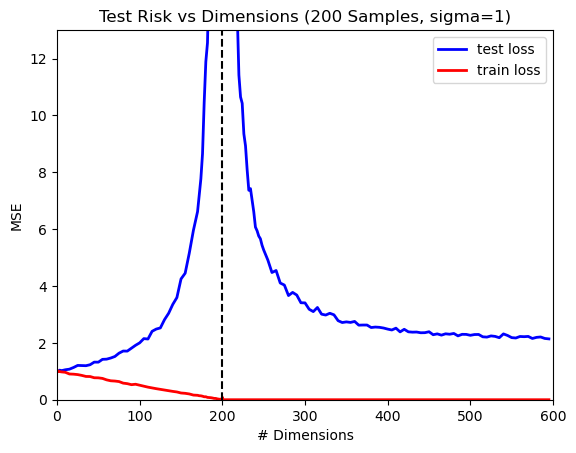

In [17]:
avgs_test_s1 = torch.mean(test_mse_s1, 1)
avgs_test_s2 = torch.mean(test_mse_s2, 1)
avgs_test_s3 = torch.mean(test_mse_s3, 1)

avgs_train_s1 = torch.mean(train_mse_s1, 1)
avgs_train_s2 = torch.mean(train_mse_s2, 1)
avgs_train_s3 = torch.mean(train_mse_s3, 1)

plt.title("Test Risk vs Dimensions (200 Samples, sigma=1)")
plt.xlabel("# Dimensions")
plt.ylabel("MSE")
plt.ylim(0, 13)
plt.xlim(0, max_dim)
plt.plot(d_vals.cpu().numpy(), avgs_test_s3.cpu().numpy(),  lw=2, color='blue',
         label='test loss')
plt.plot(d_vals.cpu().numpy(), avgs_train_s3.cpu().numpy(), lw=2, color='red',
         label='train loss')
plt.axvline(x=n, color='black', ls='--')
plt.legend(loc="best")
plt.show()